In [99]:
%load_ext autoreload
import sys
import os
import numpy as np
import sets
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tinydb
from tinydb import Query


SPARTAN_SOURCE_DIR = os.getenv('SPARTAN_SOURCE_DIR')
sys.path.append(os.path.join(SPARTAN_SOURCE_DIR, 'src/ContactParticleFilter/python'))

import lcm
import experimentanalyzer
import utils as cpfUtils
import spartan.utils.utils as spartanUtils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# logFolderName="20180105-165005_simulation"
logFolderName="20180111-161321_simulation"
ea = experimentanalyzer.ExperimentAnalyzer(logFolderName=logFolderName)
ea.run()

configFilename = os.path.join(cpfUtils.getCPFSourceDir(), 'config', 'experiments', 'cpf_experiment_config.yaml')
config = spartanUtils.getDictFromYamlFilename(configFilename)

pose_names = config["poses"]
force_names = config["force_names"]
noise_levels = config["noise_levels"]

last noise level special logic
last noise level special logic


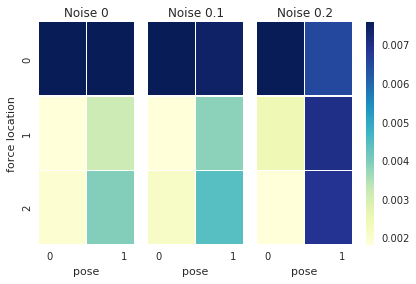

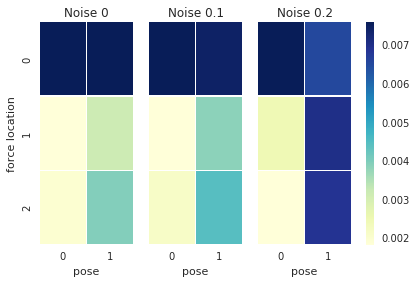

In [152]:
# pose_names = sets.Set()
# force_names = sets.Set()
# for entry in ea.db_analysis.all():
#     pose_names.add(entry['pose_name'])
#     force_names.add(entry['force_name'])

color = ['r','g','b']

"""
Make heatmap of average position error.
x-axis: contact location
y-axis: robot pose

should be three tables, one for each noise level 
"""
def contact_location_accuracy_heatmap(pose_names, force_names, db_analysis, noise_levels):
    num_poses = len(pose_names)
    num_forces = len(force_names)
    bar_width = 0.7/num_poses
    
    template = np.zeros([num_forces, num_poses])
    
    pos = dict()
    force = dict()
    
#     std_dev = dict()
#     std_dev = np.zeros([num_forces, num_poses])
    
    
    
    force_val = np.zeros([num_forces, num_poses])
    force_std_dev = np.zeros([num_forces, num_poses])
    
    
    width_ratios = [1]*len(noise_levels)
    width_ratios.append(0.08)
    pos_fix, pos_ax = plt.subplots(1, len(noise_levels)+1, gridspec_kw={'width_ratios':width_ratios})
       
    for k, noise_level in enumerate(noise_levels):
        pos[noise_level] = np.copy(template)
        force[noise_level] = np.copy(template)
        pos_vals = pos[noise_level]
        force_vals = force[noise_level]
        for j, pose_name in enumerate(pose_names):
            for i, force_name in enumerate(force_names):
                q = tinydb.Query()
                res = ea.db_analysis.search( (q.pose_name == pose_name) & (q.force_name == force_name)
                                           & (q.noise_level == noise_level) )[0]
                pos_vals[i,j] = res['stats']['position']['mean']
#                 std_dev[i,j] = res['stats']['position']['std_dev']

                force_vals[i,j] = res['stats']['force']['mean']
#                 force_std_dev[i,j] = res['stats']['force']['std_dev']


    # now we make the plots
    kwargs = {'linewidths': 0.5, 'square': True}
    pos_axcb = pos_ax[-1]
    for k, noise_level in enumerate(noise_levels):
        ax = pos_ax[k]
        
        # special logic it's the rightmost one
        if k == (len(noise_levels) - 1):
            print "last noise level special logic"
            g = sns.heatmap(pos[noise_level], cmap="YlGnBu", ax=ax, cbar=True, cbar_ax=pos_axcb,**kwargs)
            
        else:
            g = sns.heatmap(pos[noise_level], cmap="YlGnBu", cbar=False, ax=ax , **kwargs)    
        
        g.set_xlabel('pose')
        title = "Noise " + str(noise_level)
        g.set_title(title)
        
        if k == 0:
            g.set_ylabel('force location')
        
        if k > 0:
            g.set_yticks([])
            

    makeSubplotAcrossNoiseLevels(pos, noise_levels)
#         # join the y_axes
#         if k > 0:
#             pos_ax[0].get_shared_y_axes().join(pos_ax[k])
            
    pos_ax[0].get_shared_y_axes().join(*pos_ax[0:-1])
    plt.show()
        
def makeSubplotAcrossNoiseLevels(data, noise_levels, xlabel="pose", ylabel="force location"):
    width_ratios = [1]*len(noise_levels)
    width_ratios.append(0.08)
    fig, axes = plt.subplots(1, len(noise_levels)+1, gridspec_kw={'width_ratios':width_ratios})
    
    # now we make the plots
    kwargs = dict()
    kwargs['linewidths'] = 0.5
#     kwargs['square'] = True
    axcb = axes[-1]
    for k, noise_level in enumerate(noise_levels):
        ax = axes[k]
        
        # special logic it's the rightmost one
        if k == (len(noise_levels) - 1):
            print "last noise level special logic"
            g = sns.heatmap(data[noise_level], cmap="YlGnBu", ax=ax, cbar=True, cbar_ax=axcb, **kwargs)
            
        else:
            g = sns.heatmap(data[noise_level], cmap="YlGnBu", cbar=False, ax=ax ,  **kwargs)    
        
        g.set_xlabel(xlabel)
        title = "Noise " + str(noise_level)
        g.set_title(title)
        
        if k == 0:
            g.set_ylabel(ylabel)
        
        if k > 0:
            g.set_yticks([])
            
#     print "\n"
#     print "position"
#     plt.figure()
#     ax_position = sns.heatmap(vals, cmap="YlGnBu")
    
    
#     print "force"
#     plt.figure()
#     ax_force = sns.heatmap(force_val, cmap="YlGnBu")
#     return ax

    
"""
Heatmap
"""

# def contact_location_accuracy_vs_contact_location(pose_names, force_names, db_analysis, noise_level=None):
    

contact_location_accuracy_heatmap(pose_names, force_names, ea.db_analysis, noise_levels)

# Simulation Only Figures
We should make several heatmaps showing the results for simulation from the kuka
- Contact location accuracy for each (force_location, robot_pose) pair
- Contact Force Accuracy for each (force_location, robot_pose) pair

In [48]:
q = Query()
e = ea.db_analysis.search((q.pose_name == "q_nom_down") & (q.force_name == 'iiwa_link_6_1'))[0]
print e['lcm_log_file']

20180105-165102.lcm


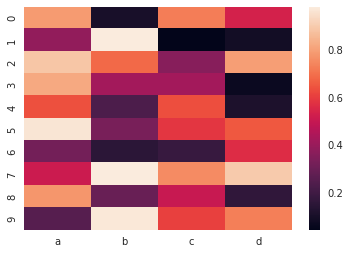

In [55]:
uniform_data = np.random.rand(10, 4)
labels = ['a','b','c','d']

ax = sns.heatmap(uniform_data, xticklabels=labels)

In [111]:
a = [1,2,3]
b = a.pop(0)
print b
print a[0:-1]

1
[2]


In [105]:
a = np.zeros(2)
b = np.copy(a)
a[0]

AttributeError: 'module' object has no attribute 'deepcopy'